In [1]:
import pandas as pd
import numpy as np
import warnings;warnings.simplefilter('ignore')
import os
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh,Dropout
import torch.optim as optim
import matplotlib.pyplot as plt

root = '../data/phase_2/raw/other/'
os.listdir(root)

['附件二.xlsx',
 '200mb201909.csv',
 'FCFC Import Naphtha Composition Lab_001~100_R2.xlsx',
 'Aroma-1 Unit 000 Split_Factor Calculation.xlsx',
 '200mb201701r2.csv',
 '附件一.xlsx']

# load data

In [2]:
data = pd.read_csv(root+"200mb201701r2.csv", encoding = 'big5', header = 0)
print('讀檔案 : ' + str(data.shape))
testdata = pd.read_csv(root+"200mb201909.csv", encoding = 'big5', header = 0)
# steam = dcs['ARO1-DCS-FIC55301'] + dcs['ARO1-DCS-FIC55501'] + dcs['ARO1-DCS-FIC55601']
# dcs['steam'] = steam
C9A = data['Feed    C9 Aromtics'] + data['Feed    C10+ Aromtics']
AROMA = data['Product    C9 Aromtics'] + data['Product    C10+ Aromtics']+ data['Product    Benzene']+ data['Product    Toluene']+ data['Product    Ethylbenzene']+ data['Product    P-Xylene']+ data['Product    M-Xylene']+ data['Product    O-Xylene']
data['C9A'] = C9A
data['AROMA'] = AROMA
C9A = testdata['Feed    C9 Aromtics'] + testdata['Feed    C10+ Aromtics']
AROMA = testdata['Product    C9 Aromtics'] + testdata['Product    C10+ Aromtics']+ testdata['Product    Benzene']+ testdata['Product    Toluene']+ testdata['Product    Ethylbenzene']+ testdata['Product    P-Xylene']+ testdata['Product    M-Xylene']+ testdata['Product    O-Xylene']
testdata['C9A'] = C9A
testdata['AROMA'] = AROMA

print ("Shape Of The Before Ouliers: ",data.shape)
data = data[(data["Naphtha Feed Rate, m3/hr"]<=100 )&(data["Naphtha Feed Rate, m3/hr"] >= 99)]
print ("Shape Of The After Ouliers: ",data.shape)
print ("Shape Of The Before Ouliers: ",testdata.shape)
testdata = testdata[(testdata["Naphtha Feed Rate, m3/hr"]<=100 )&(testdata["Naphtha Feed Rate, m3/hr"] >= 99)]
print ("Shape Of The After Ouliers: ",testdata.shape)
testdata.index = range(len(testdata))

讀檔案 : (829, 108)
Shape Of The Before Ouliers:  (829, 110)
Shape Of The After Ouliers:  (576, 110)
Shape Of The Before Ouliers:  (27, 110)
Shape Of The After Ouliers:  (20, 110)


# x_col

In [3]:
x_col  = [
"    N+2A in Naphtha Feed, wt%", #"ARO1-LIMS-s201-Naphthenes-ALL" + 2*"ARO1-LIMS-s201-Aromatics-ALL"
"    Chlorine in Fresh Catalyst, wt%", #"ARO1-LIMS-S307-CL"
"Carbon in Spent Catalyst, %",  #"ARO1-LIMS-S301-CARBON"  
"    C6P- in Naphtha Feed, wt%",  #"ARO1-LIMS-s201-Paraffins-6"  
"    3R211 Inlet Tem, oC",  #"ARO1-DCS-TIC20102 Setpoint"
"    3R212 Inlet Temp, oC", #"ARO1-DCS-TIC20202 Setpoint"
"    3R213 Inlet Temp, oC", #"ARO1-DCS-TIC20302 Setpoint"
"    3R214 Inlet Temp, oC", #"ARO1-DCS-TIC20402 Setpoint"
"Feed    Hydrogen",
"Feed    Methane",
"Feed    Ethane",
"Feed    Propane",
"Feed    n-Butane",
"Feed    i-Butane",
"Feed    C4 Naphthenes",
"Feed    n-Pentane",
"Feed    C5 i-Paraffins",
"Feed    C5 Naphthenes",
"Feed    n-Hexane",
"Feed    C6 i-Paraffins",
"Feed    C6 Naphthenes",
"Feed    Benzene",
"Feed    n-Heptane",
"Feed    C7 i-Paraffins",
"Feed    C7 Naphthenes",
"Feed    Toluene",
"Feed    n-Octane",
"Feed    C8 i-Paraffins",
"Feed    C8 Naphthenes",
"Feed    Ethylbenzene",
"Feed    P-Xylene",
"Feed    M-Xylene",
"Feed    O-Xylene",
"Feed    n-Nonane",
"Feed    C9 i-Paraffins",
"Feed    C9 Naphthenes",
"Feed    C9 Aromtics",
"Feed    C10+ n-Paraffins",
"Feed    C10+ i-Paraffins",
"Feed    C10+ Naphthenes",
"Feed    C10+ Aromtics",
"Product Separator Pressure, kg/cm2_g", #"ARO1-DCS-PIC21501 Setpoint"
# "Product Separator Temp, oC",
"H2/HC Ratio"                           #"ARO1-DCS-R211_HC"
         
         ]

In [4]:
x_col

['    N+2A in Naphtha Feed, wt%',
 '    Chlorine in Fresh Catalyst, wt%',
 'Carbon in Spent Catalyst, %',
 '    C6P- in Naphtha Feed, wt%',
 '    3R211 Inlet Tem, oC',
 '    3R212 Inlet Temp, oC',
 '    3R213 Inlet Temp, oC',
 '    3R214 Inlet Temp, oC',
 'Feed    Hydrogen',
 'Feed    Methane',
 'Feed    Ethane',
 'Feed    Propane',
 'Feed    n-Butane',
 'Feed    i-Butane',
 'Feed    C4 Naphthenes',
 'Feed    n-Pentane',
 'Feed    C5 i-Paraffins',
 'Feed    C5 Naphthenes',
 'Feed    n-Hexane',
 'Feed    C6 i-Paraffins',
 'Feed    C6 Naphthenes',
 'Feed    Benzene',
 'Feed    n-Heptane',
 'Feed    C7 i-Paraffins',
 'Feed    C7 Naphthenes',
 'Feed    Toluene',
 'Feed    n-Octane',
 'Feed    C8 i-Paraffins',
 'Feed    C8 Naphthenes',
 'Feed    Ethylbenzene',
 'Feed    P-Xylene',
 'Feed    M-Xylene',
 'Feed    O-Xylene',
 'Feed    n-Nonane',
 'Feed    C9 i-Paraffins',
 'Feed    C9 Naphthenes',
 'Feed    C9 Aromtics',
 'Feed    C10+ n-Paraffins',
 'Feed    C10+ i-Paraffins',
 'Feed    C10+ 

# y_col

In [5]:
script = '''
y1 = data["Product    Hydrogen"]
y2 = data["Product    Methane"]
y3 = data["Product    Ethane"]
y4 = data["Product    Propane"]
y5 = data["Product    n-Butane"]
y6 = data["Product    i-Butane"]
y7 = data["Product    C4 Naphthenes"]
y8 = data["Product    n-Pentane"]
y9 = data["Product    C5 i-Paraffins"]
y10 = data["Product    C5 Naphthenes"]
y11 = data["Product    n-Hexane"]
y12 = data["Product    C6 i-Paraffins"]
y13 = data["Product    C6 Naphthenes"]
y14 = data["Product    Benzene"]
y15 = data["Product    n-Heptane"]
y16 = data["Product    C7 i-Paraffins"]
y17 = data["Product    C7 Naphthenes"]
y18 = data["Product    Toluene"]
y19 = data["Product    n-Octane"]
y20 = data["Product    C8 i-Paraffins"]
y21 = data["Product    C8 Naphthenes"]
y22 = data["Product    Ethylbenzene"]
y23 = data["Product    P-Xylene"]
y24 = data["Product    M-Xylene"]
y25 = data["Product    O-Xylene"]
y26 = data["Product    n-Nonane"]
y27 = data["Product    C9 i-Paraffins"]
y28 = data["Product    C9 Naphthenes"]
y29 = data["Product    C9 Aromtics"]
y30 = data["Product    C10+ n-Paraffins"]
y31 = data["Product    C10+ i-Paraffins"]
y32 = data["Product    C10+ Naphthenes"]
y33 = data["Product    C10+ Aromtics"]
'''

In [6]:
y_col = []
for i in script.split('\n'):
    if ('[' in i)&(']'in i)&('Product' in i):
        s = i.index('["')+2
        e = i.index('"]')
        y_col.append(i[s:e])
y_col

['Product    Hydrogen',
 'Product    Methane',
 'Product    Ethane',
 'Product    Propane',
 'Product    n-Butane',
 'Product    i-Butane',
 'Product    C4 Naphthenes',
 'Product    n-Pentane',
 'Product    C5 i-Paraffins',
 'Product    C5 Naphthenes',
 'Product    n-Hexane',
 'Product    C6 i-Paraffins',
 'Product    C6 Naphthenes',
 'Product    Benzene',
 'Product    n-Heptane',
 'Product    C7 i-Paraffins',
 'Product    C7 Naphthenes',
 'Product    Toluene',
 'Product    n-Octane',
 'Product    C8 i-Paraffins',
 'Product    C8 Naphthenes',
 'Product    Ethylbenzene',
 'Product    P-Xylene',
 'Product    M-Xylene',
 'Product    O-Xylene',
 'Product    n-Nonane',
 'Product    C9 i-Paraffins',
 'Product    C9 Naphthenes',
 'Product    C9 Aromtics',
 'Product    C10+ n-Paraffins',
 'Product    C10+ i-Paraffins',
 'Product    C10+ Naphthenes',
 'Product    C10+ Aromtics']

# get  cleaned data

In [7]:
X_train = data[x_col]
X_test = testdata[x_col]
y_train = data[y_col]
y_test = testdata[y_col]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((576, 43), (576, 33), (20, 43), (20, 33))

# group x_col

In [8]:
sum_col = ['Feed    Methane','Feed    Ethane','Feed    n-Butane',
          'Feed    i-Butane','Feed    C4 Naphthenes','Feed    n-Pentane','Feed    C5 i-Paraffins',
          'Feed    C5 Naphthenes','Feed    C6 i-Paraffins']

In [9]:
#print(X_train.shape)
#X_train['Feed    C6 i-Paraffins'] = X_train[sum_col].sum(axis=1)
#X_train = X_train.drop(sum_col,axis=1)
#print(X_train.shape)

In [10]:
#print(X_test.shape)
#X_test['Feed    C6 i-Paraffins'] = X_test[sum_col].sum(axis=1)
#X_test = X_test.drop(sum_col,axis=1)
#print(X_test.shape)

In [11]:
x_col = X_train.columns.tolist()
print(len(x_col))

43


# scale data

In [12]:
from sklearn.preprocessing import MinMaxScaler

mm_x = MinMaxScaler()
mm_x.fit(X_train.append(X_test))

mm_y = MinMaxScaler()
mm_y.fit(y_train.append(y_test))

X_train[:] = mm_x.transform(X_train[:])
X_test[:] = mm_x.transform(X_test[:])

y_train[:] = mm_y.transform(y_train[:])
y_test[:] = mm_y.transform(y_test[:])

# torch data_iter

In [13]:
X_train = torch.tensor(X_train.values,dtype=torch.float)#.cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float)#.cuda()

y_train = torch.tensor(y_train.values,dtype=torch.float)#.cuda()
y_test = torch.tensor(y_test.values,dtype=torch.float)#.cuda()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128,shuffle=True)

# define model

In [14]:
class model4333(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(model4333,self).__init__()
        self.fc1 = Linear(input_shape,256,bias=False)
        self.fc2 = Linear(256,128,bias=False)
        self.fc3 = Linear(128,output_shape,bias=False)
        self.dropout = Dropout(0.5)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))
        return x

In [15]:
def init_weights(m):
    if hasattr(m,'weight'):
        try:
            torch.nn.init.xavier_uniform(m.weight)
        except:
            pass
    if hasattr(m,'bias'):
        try:
            m.bias.data.fill_(0.01)
        except:
            pass

In [16]:
net = model4333(len(x_col),len(y_col))#.cuda()
net.apply(init_weights)

model4333(
  (fc1): Linear(in_features=43, out_features=256, bias=False)
  (fc2): Linear(in_features=256, out_features=128, bias=False)
  (fc3): Linear(in_features=128, out_features=33, bias=False)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
net(X_test[0])

tensor([0.5233, 0.5143, 0.4295, 0.4949, 0.4870, 0.5330, 0.5608, 0.5159, 0.5782,
        0.5282, 0.3680, 0.5891, 0.3554, 0.4374, 0.5057, 0.5788, 0.4602, 0.5087,
        0.4650, 0.5492, 0.5866, 0.5438, 0.5487, 0.6030, 0.4607, 0.4288, 0.5260,
        0.5645, 0.5421, 0.5180, 0.5091, 0.5229, 0.5452],
       grad_fn=<SigmoidBackward>)

# loss and opt

In [18]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [19]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0591 valid loss 0.0480
record net
epochs 1 train loss 0.0463 valid loss 0.0351
record net
epochs 2 train loss 0.0373 valid loss 0.0260
record net
epochs 3 train loss 0.0329 valid loss 0.0213
record net
epochs 4 train loss 0.0302 valid loss 0.0191
record net
epochs 5 train loss 0.0273 valid loss 0.0187
record net
epochs 6 train loss 0.0254 valid loss 0.0183
record net
epochs 7 train loss 0.0241 valid loss 0.0176
record net
epochs 8 train loss 0.0228 valid loss 0.0166
record net
epochs 9 train loss 0.0221 valid loss 0.0161
record net
epochs 10 train loss 0.0208 valid loss 0.0155
record net
epochs 11 train loss 0.0202 valid loss 0.0151
record net
epochs 12 train loss 0.0191 valid loss 0.0145
record net
epochs 13 train loss 0.0186 valid loss 0.0140
record net
epochs 14 train loss 0.0183 valid loss 0.0134
record net
epochs 15 train loss 0.0175 valid loss 0.0130
record net
epochs 16 train loss 0.0168 valid loss 0.0125
record net
epochs 17 train loss 0.0165 valid loss 0.

epochs 164 train loss 0.0085 valid loss 0.0066
epochs 165 train loss 0.0087 valid loss 0.0064
record net
epochs 166 train loss 0.0089 valid loss 0.0064
record net
epochs 167 train loss 0.0086 valid loss 0.0064
record net
epochs 168 train loss 0.0089 valid loss 0.0064
epochs 169 train loss 0.0088 valid loss 0.0065
epochs 170 train loss 0.0091 valid loss 0.0065
epochs 171 train loss 0.0088 valid loss 0.0063
record net
epochs 172 train loss 0.0087 valid loss 0.0063
record net
epochs 173 train loss 0.0089 valid loss 0.0065
epochs 174 train loss 0.0088 valid loss 0.0066
epochs 175 train loss 0.0087 valid loss 0.0064
epochs 176 train loss 0.0087 valid loss 0.0065
epochs 177 train loss 0.0090 valid loss 0.0063
epochs 178 train loss 0.0087 valid loss 0.0065
epochs 179 train loss 0.0089 valid loss 0.0063
epochs 180 train loss 0.0087 valid loss 0.0064
epochs 181 train loss 0.0088 valid loss 0.0063
epochs 182 train loss 0.0083 valid loss 0.0063
epochs 183 train loss 0.0091 valid loss 0.0063
epoch

epochs 335 train loss 0.0072 valid loss 0.0051
epochs 336 train loss 0.0075 valid loss 0.0050
epochs 337 train loss 0.0076 valid loss 0.0050
epochs 338 train loss 0.0076 valid loss 0.0049
record net
epochs 339 train loss 0.0073 valid loss 0.0050
epochs 340 train loss 0.0075 valid loss 0.0050
epochs 341 train loss 0.0072 valid loss 0.0049
record net
epochs 342 train loss 0.0072 valid loss 0.0050
epochs 343 train loss 0.0073 valid loss 0.0050
epochs 344 train loss 0.0074 valid loss 0.0050
epochs 345 train loss 0.0075 valid loss 0.0052
epochs 346 train loss 0.0075 valid loss 0.0049
epochs 347 train loss 0.0074 valid loss 0.0048
record net
epochs 348 train loss 0.0072 valid loss 0.0049
epochs 349 train loss 0.0075 valid loss 0.0051
epochs 350 train loss 0.0073 valid loss 0.0050
epochs 351 train loss 0.0073 valid loss 0.0049
epochs 352 train loss 0.0073 valid loss 0.0049
epochs 353 train loss 0.0075 valid loss 0.0049
epochs 354 train loss 0.0074 valid loss 0.0049
epochs 355 train loss 0.007

epochs 511 train loss 0.0066 valid loss 0.0042
epochs 512 train loss 0.0065 valid loss 0.0041
record net
epochs 513 train loss 0.0068 valid loss 0.0042
epochs 514 train loss 0.0065 valid loss 0.0043
epochs 515 train loss 0.0067 valid loss 0.0042
epochs 516 train loss 0.0067 valid loss 0.0043
epochs 517 train loss 0.0066 valid loss 0.0041
record net
epochs 518 train loss 0.0066 valid loss 0.0043
epochs 519 train loss 0.0066 valid loss 0.0042
epochs 520 train loss 0.0066 valid loss 0.0042
epochs 521 train loss 0.0066 valid loss 0.0041
epochs 522 train loss 0.0065 valid loss 0.0041
epochs 523 train loss 0.0064 valid loss 0.0042
epochs 524 train loss 0.0066 valid loss 0.0040
record net
epochs 525 train loss 0.0064 valid loss 0.0041
epochs 526 train loss 0.0067 valid loss 0.0041
epochs 527 train loss 0.0065 valid loss 0.0041
epochs 528 train loss 0.0066 valid loss 0.0041
epochs 529 train loss 0.0065 valid loss 0.0040
epochs 530 train loss 0.0067 valid loss 0.0042
epochs 531 train loss 0.006

epochs 685 train loss 0.0063 valid loss 0.0037
epochs 686 train loss 0.0062 valid loss 0.0036
record net
epochs 687 train loss 0.0060 valid loss 0.0036
epochs 688 train loss 0.0063 valid loss 0.0038
epochs 689 train loss 0.0060 valid loss 0.0037
epochs 690 train loss 0.0062 valid loss 0.0037
epochs 691 train loss 0.0062 valid loss 0.0036
epochs 692 train loss 0.0061 valid loss 0.0036
epochs 693 train loss 0.0057 valid loss 0.0036
epochs 694 train loss 0.0060 valid loss 0.0037
epochs 695 train loss 0.0060 valid loss 0.0036
record net
epochs 696 train loss 0.0064 valid loss 0.0036
epochs 697 train loss 0.0061 valid loss 0.0037
epochs 698 train loss 0.0062 valid loss 0.0038
epochs 699 train loss 0.0062 valid loss 0.0037
epochs 700 train loss 0.0063 valid loss 0.0036
epochs 701 train loss 0.0063 valid loss 0.0035
record net
epochs 702 train loss 0.0061 valid loss 0.0036
epochs 703 train loss 0.0060 valid loss 0.0036
epochs 704 train loss 0.0062 valid loss 0.0036
epochs 705 train loss 0.006

epochs 856 train loss 0.0058 valid loss 0.0032
epochs 857 train loss 0.0057 valid loss 0.0032
epochs 858 train loss 0.0057 valid loss 0.0032
record net
epochs 859 train loss 0.0056 valid loss 0.0034
epochs 860 train loss 0.0059 valid loss 0.0034
epochs 861 train loss 0.0061 valid loss 0.0033
epochs 862 train loss 0.0057 valid loss 0.0032
epochs 863 train loss 0.0058 valid loss 0.0032
epochs 864 train loss 0.0058 valid loss 0.0032
epochs 865 train loss 0.0058 valid loss 0.0034
epochs 866 train loss 0.0060 valid loss 0.0032
epochs 867 train loss 0.0060 valid loss 0.0032
epochs 868 train loss 0.0057 valid loss 0.0032
epochs 869 train loss 0.0059 valid loss 0.0031
record net
epochs 870 train loss 0.0058 valid loss 0.0033
epochs 871 train loss 0.0056 valid loss 0.0033
epochs 872 train loss 0.0058 valid loss 0.0033
epochs 873 train loss 0.0058 valid loss 0.0033
epochs 874 train loss 0.0058 valid loss 0.0032
epochs 875 train loss 0.0056 valid loss 0.0033
epochs 876 train loss 0.0057 valid los

epochs 1028 train loss 0.0055 valid loss 0.0030
epochs 1029 train loss 0.0053 valid loss 0.0029
record net
epochs 1030 train loss 0.0056 valid loss 0.0029
epochs 1031 train loss 0.0057 valid loss 0.0029
epochs 1032 train loss 0.0057 valid loss 0.0029
epochs 1033 train loss 0.0052 valid loss 0.0030
epochs 1034 train loss 0.0054 valid loss 0.0030
epochs 1035 train loss 0.0057 valid loss 0.0030
epochs 1036 train loss 0.0055 valid loss 0.0030
epochs 1037 train loss 0.0053 valid loss 0.0029
epochs 1038 train loss 0.0057 valid loss 0.0029
record net
epochs 1039 train loss 0.0054 valid loss 0.0029
epochs 1040 train loss 0.0054 valid loss 0.0030
epochs 1041 train loss 0.0054 valid loss 0.0029
epochs 1042 train loss 0.0056 valid loss 0.0030
epochs 1043 train loss 0.0055 valid loss 0.0029
epochs 1044 train loss 0.0055 valid loss 0.0029
epochs 1045 train loss 0.0055 valid loss 0.0029
epochs 1046 train loss 0.0056 valid loss 0.0029
epochs 1047 train loss 0.0053 valid loss 0.0029
epochs 1048 train 

epochs 1198 train loss 0.0055 valid loss 0.0027
epochs 1199 train loss 0.0054 valid loss 0.0027
epochs 1200 train loss 0.0053 valid loss 0.0027
epochs 1201 train loss 0.0054 valid loss 0.0027
epochs 1202 train loss 0.0051 valid loss 0.0027
epochs 1203 train loss 0.0052 valid loss 0.0028
epochs 1204 train loss 0.0052 valid loss 0.0028
epochs 1205 train loss 0.0052 valid loss 0.0027
epochs 1206 train loss 0.0052 valid loss 0.0027
epochs 1207 train loss 0.0052 valid loss 0.0027
epochs 1208 train loss 0.0052 valid loss 0.0027
epochs 1209 train loss 0.0053 valid loss 0.0027
epochs 1210 train loss 0.0054 valid loss 0.0028
epochs 1211 train loss 0.0052 valid loss 0.0028
epochs 1212 train loss 0.0052 valid loss 0.0027
epochs 1213 train loss 0.0053 valid loss 0.0027
epochs 1214 train loss 0.0051 valid loss 0.0027
epochs 1215 train loss 0.0055 valid loss 0.0028
epochs 1216 train loss 0.0056 valid loss 0.0027
epochs 1217 train loss 0.0053 valid loss 0.0027
epochs 1218 train loss 0.0054 valid loss

epochs 1377 train loss 0.0050 valid loss 0.0025
epochs 1378 train loss 0.0051 valid loss 0.0025
epochs 1379 train loss 0.0051 valid loss 0.0027
epochs 1380 train loss 0.0053 valid loss 0.0025
epochs 1381 train loss 0.0050 valid loss 0.0025
epochs 1382 train loss 0.0051 valid loss 0.0025
epochs 1383 train loss 0.0051 valid loss 0.0025
epochs 1384 train loss 0.0050 valid loss 0.0026
epochs 1385 train loss 0.0050 valid loss 0.0026
epochs 1386 train loss 0.0052 valid loss 0.0026
epochs 1387 train loss 0.0054 valid loss 0.0026
epochs 1388 train loss 0.0051 valid loss 0.0025
record net
epochs 1389 train loss 0.0049 valid loss 0.0025
epochs 1390 train loss 0.0051 valid loss 0.0025
epochs 1391 train loss 0.0052 valid loss 0.0024
record net
epochs 1392 train loss 0.0053 valid loss 0.0025
epochs 1393 train loss 0.0049 valid loss 0.0025
epochs 1394 train loss 0.0052 valid loss 0.0025
epochs 1395 train loss 0.0051 valid loss 0.0025
epochs 1396 train loss 0.0052 valid loss 0.0025
epochs 1397 train 

epochs 1548 train loss 0.0048 valid loss 0.0023
record net
epochs 1549 train loss 0.0049 valid loss 0.0024
epochs 1550 train loss 0.0047 valid loss 0.0024
epochs 1551 train loss 0.0051 valid loss 0.0025
epochs 1552 train loss 0.0052 valid loss 0.0025
epochs 1553 train loss 0.0050 valid loss 0.0025
epochs 1554 train loss 0.0051 valid loss 0.0025
epochs 1555 train loss 0.0054 valid loss 0.0023
record net
epochs 1556 train loss 0.0048 valid loss 0.0024
epochs 1557 train loss 0.0048 valid loss 0.0024
epochs 1558 train loss 0.0051 valid loss 0.0024
epochs 1559 train loss 0.0050 valid loss 0.0024
epochs 1560 train loss 0.0050 valid loss 0.0025
epochs 1561 train loss 0.0051 valid loss 0.0024
epochs 1562 train loss 0.0051 valid loss 0.0025
epochs 1563 train loss 0.0051 valid loss 0.0024
epochs 1564 train loss 0.0051 valid loss 0.0024
epochs 1565 train loss 0.0049 valid loss 0.0024
epochs 1566 train loss 0.0051 valid loss 0.0024
epochs 1567 train loss 0.0052 valid loss 0.0024
epochs 1568 train 

epochs 1725 train loss 0.0051 valid loss 0.0025
epochs 1726 train loss 0.0048 valid loss 0.0023
epochs 1727 train loss 0.0050 valid loss 0.0023
epochs 1728 train loss 0.0051 valid loss 0.0022
epochs 1729 train loss 0.0049 valid loss 0.0023
epochs 1730 train loss 0.0048 valid loss 0.0023
epochs 1731 train loss 0.0050 valid loss 0.0023
epochs 1732 train loss 0.0049 valid loss 0.0023
epochs 1733 train loss 0.0047 valid loss 0.0023
epochs 1734 train loss 0.0049 valid loss 0.0023
epochs 1735 train loss 0.0051 valid loss 0.0023
epochs 1736 train loss 0.0050 valid loss 0.0025
epochs 1737 train loss 0.0049 valid loss 0.0023
epochs 1738 train loss 0.0048 valid loss 0.0023
epochs 1739 train loss 0.0049 valid loss 0.0023
epochs 1740 train loss 0.0051 valid loss 0.0022
epochs 1741 train loss 0.0050 valid loss 0.0023
epochs 1742 train loss 0.0049 valid loss 0.0023
epochs 1743 train loss 0.0049 valid loss 0.0023
epochs 1744 train loss 0.0050 valid loss 0.0023
epochs 1745 train loss 0.0049 valid loss

epochs 1899 train loss 0.0047 valid loss 0.0022
epochs 1900 train loss 0.0048 valid loss 0.0023
epochs 1901 train loss 0.0049 valid loss 0.0022
epochs 1902 train loss 0.0049 valid loss 0.0024
epochs 1903 train loss 0.0048 valid loss 0.0022
epochs 1904 train loss 0.0051 valid loss 0.0022
epochs 1905 train loss 0.0050 valid loss 0.0023
epochs 1906 train loss 0.0048 valid loss 0.0022
epochs 1907 train loss 0.0048 valid loss 0.0023
epochs 1908 train loss 0.0049 valid loss 0.0023
epochs 1909 train loss 0.0051 valid loss 0.0022
epochs 1910 train loss 0.0050 valid loss 0.0022
epochs 1911 train loss 0.0050 valid loss 0.0022
epochs 1912 train loss 0.0048 valid loss 0.0021
epochs 1913 train loss 0.0049 valid loss 0.0021
epochs 1914 train loss 0.0049 valid loss 0.0022
epochs 1915 train loss 0.0050 valid loss 0.0022
epochs 1916 train loss 0.0049 valid loss 0.0022
epochs 1917 train loss 0.0049 valid loss 0.0023
epochs 1918 train loss 0.0048 valid loss 0.0022
epochs 1919 train loss 0.0051 valid loss

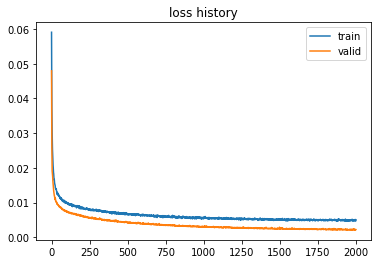

In [20]:
net = train(net,train_iter,train_iter,loss_function,optimizer,num_epochs=2000)

# make prediction

In [21]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = mm_y.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2572.183105,740.636597,2228.654053,2843.982666,1133.960571,1067.837891,0.995467,1718.391846,2597.365479,31.757473,...,10077.124023,5322.470215,6.016958,21.260946,20.454271,9421.224609,95.066360,200.812119,134.284683,1809.823730
1,2568.184326,777.222839,2211.351562,2780.290283,1160.547729,1126.910278,1.134604,1706.713257,2584.471680,35.382900,...,10155.812500,5297.695312,7.065793,24.669638,20.830187,9543.467773,96.425301,196.432526,131.573181,1855.174194
2,2565.719971,725.733887,2238.985107,2867.672119,1123.835205,1042.455688,0.989031,1718.398926,2594.660400,30.138796,...,10207.831055,5360.325195,5.574610,20.460924,19.151035,9350.967773,94.526665,202.095154,134.914703,1759.203369
3,2566.228271,777.815308,2209.218750,2782.662354,1167.314697,1135.059082,1.145762,1701.082031,2577.953369,36.027950,...,10134.573242,5288.574219,7.410050,26.712345,21.475384,9585.598633,98.702332,199.738373,134.164154,1887.047607
4,2566.082275,793.089294,2198.165039,2789.290039,1157.128906,1130.666504,1.191550,1708.462646,2590.016357,37.561871,...,10174.839844,5279.182617,7.880780,28.268747,21.291956,9616.057617,98.948318,197.383545,132.828171,1890.711426


In [22]:
y_real = y_test.cpu().detach().numpy()
y_real = mm_y.inverse_transform(y_real)
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2585.543945,783.050415,2167.787842,2652.459229,1190.827881,1204.990967,0.993305,1659.135864,2504.534424,37.759483,...,10368.238281,5203.674805,7.924977,28.818098,21.613575,9198.000977,89.397423,174.555038,119.134483,1788.525391
1,2603.471924,802.383057,2194.137207,2121.544189,1468.593384,1563.974609,0.991749,1688.823730,2555.859619,37.822845,...,10326.885742,5182.920898,8.026574,27.728163,21.890656,9217.683594,88.513573,172.790543,118.854881,1775.654785
2,2583.133789,875.061646,2180.788086,2890.277100,1133.260010,1070.766968,1.117023,1658.076660,2512.558350,37.748615,...,10314.416992,5176.662598,7.963961,27.511864,20.995895,9191.858398,94.822845,185.389496,127.154457,1778.275024
3,2569.629395,888.716736,2207.623291,2813.154541,1111.260864,1039.724121,0.992776,1702.433350,2574.746338,39.185349,...,10330.272461,5184.620117,7.294888,25.532106,21.155176,9204.890625,87.612442,169.090637,118.264397,1773.150635
4,2565.668457,887.869019,2179.576416,2809.469482,1067.980591,977.900513,1.119704,1716.807129,2595.738525,39.400585,...,10360.566406,5199.824219,7.954566,28.925694,20.971128,9265.553711,88.705460,173.766342,119.839462,1788.048950


# metric

In [23]:
from sklearn.metrics import r2_score,mean_squared_error
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Product Hydrogen,0.387579,1970.49,1.35775
Product Methane,-0.507178,14753.4,10.4272
Product Ethane,0.727381,4379.48,2.23486
Product Propane,-0.0392844,84262.3,9.07572
Product n-Butane,-0.0490643,16073.6,8.0294
Product i-Butane,0.133868,26877.7,10.4313
Product C4 Naphthenes,0.0478181,0.668558,13.5546
Product n-Pentane,0.538984,20270.7,5.80451
Product C5 i-Paraffins,0.537383,43656.3,5.70662
Product C5 Naphthenes,-6.78182,17.3538,9.33366


# wraper model

In [25]:
class model_4333_wraper:
    def __init__(self):
        self.x_col = x_col
        self.y_col = y_col
        self.mm_x = mm_x
        self.mm_y = mm_y
        self.net = net.eval()
    
    def predict(self,x):
        feed = x.iloc[:,8:8+33].sum(axis=1).values.reshape(-1,1)
        x = self.mm_x.transform(x)
        x = torch.tensor(x,dtype=torch.float)#.cuda()
        y = self.net(x)
        y = y.detach().cpu().numpy()
        y = self.mm_y.inverse_transform(y)
        y = self.normalize(y,feed)
        y = pd.DataFrame(y,columns=self.y_col)
        output = y.sum(axis=1).values.reshape(-1,1)
        assert np.allclose(feed,output)
        assert np.all(y.values >= 0)
        return y
    
    def normalize(self,x,feed):
        x = x / x.sum(axis=1).reshape(-1,1)
        x *= feed
        return x

In [26]:
model = model_4333_wraper()

In [27]:
X_test = pd.DataFrame(X_test.detach().cpu().numpy(),columns=x_col)

In [28]:
X_test[:] = mm_x.inverse_transform(X_test)

In [29]:
X_test.head()

,"N+2A in Naphtha Feed, wt%","Chlorine in Fresh Catalyst, wt%","Carbon in Spent Catalyst, %","C6P- in Naphtha Feed, wt%","3R211 Inlet Tem, oC","3R212 Inlet Temp, oC","3R213 Inlet Temp, oC","3R214 Inlet Temp, oC",Feed Hydrogen,Feed Methane,...,Feed n-Nonane,Feed C9 i-Paraffins,Feed C9 Naphthenes,Feed C9 Aromtics,Feed C10+ n-Paraffins,Feed C10+ i-Paraffins,Feed C10+ Naphthenes,Feed C10+ Aromtics,"Product Separator Pressure, kg/cm2_g",H2/HC Ratio
0,62.388248,0.944780,3.8015,0.519984,525.010925,525.000854,525.017944,516.013000,0.0,0.0,...,3517.725586,6404.042480,2514.497070,1798.867554,357.764374,1413.709961,137.142532,124.334564,4.700871,1.442642
1,63.119476,0.931290,3.8320,0.528968,525.005981,525.009521,524.994446,516.015686,0.0,0.0,...,3637.014160,6542.346680,2597.256104,1848.255615,362.016083,1410.414307,129.325073,110.656944,4.696388,1.474911
2,63.259525,0.928645,3.7630,0.551923,525.004639,525.001404,525.011169,516.004028,0.0,0.0,...,3486.991455,5947.743164,2616.527588,1728.325195,342.066620,1336.967285,122.385384,109.738213,4.700059,1.495016
3,62.810543,0.913635,3.8590,0.522963,524.466309,525.006897,524.990540,516.009033,0.0,0.0,...,3636.807373,6497.169922,2681.642822,1831.335693,366.754639,1421.607422,134.156174,112.465012,4.700067,1.475583
4,62.596931,0.913195,3.7770,0.544962,523.334412,524.333679,524.334839,515.984741,0.0,0.0,...,3628.716309,6481.561035,2682.615479,1819.025513,365.363129,1411.612915,130.418716,107.192932,4.695580,1.498736


In [30]:
y_test = pd.DataFrame(y_test.detach().cpu().numpy(),columns=y_col)

In [31]:
y_test[:] = mm_y.inverse_transform(y_test)

In [32]:
y_test.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2585.543945,783.050415,2167.787842,2652.459229,1190.827881,1204.990967,0.993305,1659.135864,2504.534424,37.759483,...,10368.238281,5203.674805,7.924977,28.818098,21.613575,9198.000977,89.397423,174.555038,119.134483,1788.525391
1,2603.471924,802.383057,2194.137207,2121.544189,1468.593384,1563.974609,0.991749,1688.823730,2555.859619,37.822845,...,10326.885742,5182.920898,8.026574,27.728163,21.890656,9217.683594,88.513573,172.790543,118.854881,1775.654785
2,2583.133789,875.061646,2180.788086,2890.277100,1133.260010,1070.766968,1.117023,1658.076660,2512.558350,37.748615,...,10314.416992,5176.662598,7.963961,27.511864,20.995895,9191.858398,94.822845,185.389496,127.154457,1778.275024
3,2569.629395,888.716736,2207.623291,2813.154541,1111.260864,1039.724121,0.992776,1702.433350,2574.746338,39.185349,...,10330.272461,5184.620117,7.294888,25.532106,21.155176,9204.890625,87.612442,169.090637,118.264397,1773.150635
4,2565.668457,887.869019,2179.576416,2809.469482,1067.980591,977.900513,1.119704,1716.807129,2595.738525,39.400585,...,10360.566406,5199.824219,7.954566,28.925694,20.971128,9265.553711,88.705460,173.766342,119.839462,1788.048950


In [33]:
y_pred = model.predict(X_test)
y_pred.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2591.226562,746.119934,2245.154053,2865.039062,1142.355957,1075.743530,1.002837,1731.114502,2616.595703,31.992596,...,10151.732422,5361.876465,6.061497,21.418329,20.605696,9490.976562,95.770210,202.298920,135.278915,1823.222778
1,2582.979980,781.700867,2224.091309,2796.307861,1167.233521,1133.402222,1.141140,1716.545898,2599.361328,35.586781,...,10214.323242,5328.216309,7.106517,24.811804,20.950201,9598.451172,96.980797,197.564102,132.331131,1865.862183
2,2590.705322,732.800842,2260.789062,2895.600098,1134.778809,1052.606445,0.998662,1735.133789,2619.928467,30.432266,...,10307.238281,5412.526367,5.628879,20.660126,19.337494,9442.028320,95.447220,204.063370,136.228653,1776.334473
3,2578.320312,781.480103,2219.628906,2795.774414,1172.815430,1140.407959,1.151160,1709.097534,2590.100830,36.197674,...,10182.327148,5313.493164,7.444952,26.838182,21.576574,9630.765625,99.167435,200.679642,134.796402,1895.939331
4,2577.071045,796.486633,2207.577393,2801.233154,1162.084229,1135.508789,1.196653,1715.778320,2601.106934,37.722801,...,10218.412109,5301.789062,7.914569,28.389936,21.383162,9657.237305,99.371986,198.228531,133.396805,1898.808350


In [34]:
y_real = y_test

In [35]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Product Hydrogen,0.447201,1778.65,1.2138
Product Methane,-0.475361,14441.9,10.2245
Product Ethane,0.67607,5203.76,2.52255
Product Propane,-0.0401284,84330.7,8.94948
Product n-Butane,-0.026068,15721.3,7.92964
Product i-Butane,0.140416,26674.4,10.3416
Product C4 Naphthenes,0.0528923,0.664996,13.5644
Product n-Pentane,0.55479,19575.7,5.7566
Product C5 i-Paraffins,0.554671,42024.9,5.6869
Product C5 Naphthenes,-6.3318,16.3502,9.05437


In [36]:
import joblib
joblib.dump(model,'../model/transformer(43_to_33).pkl')

['../model/transformer(43_to_33).pkl']